#  Building a Mixture of Experts (MoE) Model

## Overview
In this notebook, we will be constructing a **Mixture of Experts (MoE)** model, which leverages multiple expert networks along with a **gating network** to dynamically select the most suitable expert for a given input. The goal is to build a system where different experts specialize in different aspects of the input data, and the gating network intelligently decides which expert(s) should be activated based on the input's characteristics.

### Key Components:
- **Experts**: Each expert is a specialized neural network that is trained to handle specific scenarios. For example, one expert may specialize in handling images from **FarField scenarios**, while another might be focused on **Indoor settings**.
- **Gating Network**: The gating network is a CNN (possibly enhanced with an attention mechanism) that processes the input and assigns softmax weights to the experts, indicating how much each expert should contribute to the final prediction.
- **Mixture of Experts (MoE)**: The MoE model combines the outputs of the selected experts based on the gating network’s decision. The goal is to improve accuracy and efficiency by using different experts for different parts of the input data, thus enabling the model to specialize and generalize better.

### What We Will Do:
- Load pre-trained expert models and a gating network.
- Use the gating network to assign weights to the experts based on the input data.
- Combine the predictions from the experts in a weighted manner to make the final prediction.
- Evaluate the performance of the MoE model on various tasks.

The aim of this notebook is to demonstrate the power of **expert specialization** and the **gating mechanism** in improving the overall performance of the model, especially in complex or diverse scenarios.


### Loadiung the Experts and Gating Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from ultralytics import YOLO
import os
from copy import deepcopy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(dim, dim // 8, 1)
        self.key = nn.Conv2d(dim, dim // 8, 1)
        self.value = nn.Conv2d(dim, dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling

    def forward(self, x):
        batch_size, C, width, height = x.size()

        proj_query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # B x N x C'
        proj_key = self.key(x).view(batch_size, -1, width * height)  # B x C' x N
        energy = torch.bmm(proj_query, proj_key)  # B x N x N
        attention = F.softmax(energy, dim=-1)

        proj_value = self.value(x).view(batch_size, -1, width * height)  # B x C x N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))  # B x C x N
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x  # Residual connection
        return out

class GatingCNNWithAttention(nn.Module):
    def __init__(self, num_classes=4):
        super(GatingCNNWithAttention, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 224, 224]
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # [B, 32, 112, 112]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # [B, 64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # [B, 64, 56, 56]

            SelfAttention(64),  # Add Attention here!

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # [B, 128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling [B, 128, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)  # Final output for 4 scenarios
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits  # raw logits (we apply softmax separately when needed)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gating_model = GatingCNNWithAttention().to(device)
gating_model.load_state_dict(torch.load("models/improved_gating_cnn.pth", map_location=device))
gating_model.eval()

GatingCNNWithAttention(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): SelfAttention(
      (query): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): R

In [4]:
expert_paths = {
    "indoor": "models/indoor.pt",
    "outdoor": "models/outdoor.pt",
    "farfield": "models/farfield.pt",
    "satellite": "models/satellite.pt"
}

experts = [YOLO(path) for path in expert_paths.values()]


### Fire Scenario Dataset Preparation

 Each image is preprocessed by resizing to 224×224 and converting to a tensor. The dataset is split into training and validation sets using an 80/20 ratio. PyTorch `DataLoader`s are then used for batching and shuffling during inference through the gating network.


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0).to(device) 


In [16]:
def get_gate_weights(image_tensor):
    with torch.no_grad():
        logits = gating_model(image_tensor)
        probs = F.softmax(logits, dim=1)  # shape: (1, 4)
        
    return probs.squeeze().cpu().numpy()


###  Running the Mixture of Experts (MoE) Inference

In this section, we define the `run_moe` functi, which utilizes the outputs from multiple expert models and combines them using **Weighted Box Fusion (WBF)**. The steps involved are as follows:

1. **Preprocessing**: The image is preprocessed into a tensor format suitable for the experts and gating network.
   
2. **Gating Network**: The gating network assigns a weight to each expert based on the processed image, which determines how much influence each expert will have on the final prediction.

3. **Expert Predictions**: Each expert model is run independently on the image, and its predictions are scaled by the corresponding gating weight. The predictions include bounding boxes, confidences, and class labels.

4. **Weighted Box Fusion (WBF)**: The bounding boxes and predictions from all experts are merged using **Weighted Box Fusion** (WBF). This technique combines the predicted boxes from multiple sources while suppressing duplicate or low-confidence boxes based on their overlap (IoU). It also ensures that the most confident predictions are prioritized.

5. **Rescaling**: The box coordinates are normalized to the image dimensions before performing the WBF. After fusion, the coordinates are rescaled back to the original image dimensions.

6. **Returning Predictions**: The final boxes, confidences, and labels are returned as a `Boxes` object, ready for use in downstream tasks like evaluation or visualization.

The goal of this method is to combine the strengths of multiple experts in a manner that improves the overall accuracy and robustness of the object detection model.


In [17]:
from ensemble_boxes import weighted_boxes_fusion
from ultralytics.engine.results import Boxes
import numpy as np
def run_moe(image_path, conf_threshold=0.3, iou_threshold=0.5):
    # Step 1: Preprocess the image
    img_tensor = preprocess_image(image_path)
    
    # Step 2: Get expert weights from gating model
    gate_weights = get_gate_weights(img_tensor)
    # print("Gating weights:", gate_weights)

    all_boxes_raw = []

    # Step 3: Run each expert and collect weighted predictions
    for i, expert in enumerate(experts):
        result = expert(image_path, verbose=False)[0]
        weight = gate_weights[i]
        if result.boxes is not None and result.boxes.conf is not None:
            conf = result.boxes.conf * weight
            keep_mask = conf > conf_threshold

            if keep_mask.sum() > 0:
                xyxy = result.boxes.xyxy[keep_mask]
                conf = conf[keep_mask]
                cls = result.boxes.cls[keep_mask]

                combined = torch.cat([xyxy, conf.unsqueeze(1), cls.unsqueeze(1)], dim=1)
                all_boxes_raw.append(combined)

    # Step 4: If no boxes from any expert, return empty
    if not all_boxes_raw:
        return []

    # Step 5: Merge boxes using Weighted Box Fusion
    all_boxes_combined = torch.cat(all_boxes_raw, dim=0)
    boxes = all_boxes_combined[:, :4]  # x1, y1, x2, y2
    scores = all_boxes_combined[:, 4]  # confidence
    classes = all_boxes_combined[:, 5]  # class (fire=0)

    # Normalize box coordinates for WBF
    img = Image.open(image_path)
    img_w, img_h = img.size

    norm_boxes = boxes.clone()
    norm_boxes[:, [0, 2]] /= img_w
    norm_boxes[:, [1, 3]] /= img_h

    # Prepare for WBF
    boxes_list = [norm_boxes.cpu().numpy().tolist()]
    scores_list = [scores.cpu().numpy().tolist()]
    labels_list = [classes.cpu().numpy().tolist()]

    boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion(
        boxes_list, scores_list, labels_list,
        iou_thr=iou_threshold,
        skip_box_thr=conf_threshold
    )

    # Rescale boxes back to image dimensions
    boxes_wbf = np.array(boxes_wbf)
    boxes_wbf[:, [0,2]] *= img_w
    boxes_wbf[:, [1,3]] *= img_h

    final_tensor = torch.tensor(np.hstack([
        boxes_wbf,
        np.array(scores_wbf).reshape(-1,1),
        np.array(labels_wbf).reshape(-1,1)
    ]), dtype=torch.float32)

    kept_boxes = Boxes(final_tensor, orig_shape=(img_h, img_w))

    return [kept_boxes]

###  Evaluation of the Mixture of Experts (MoE) Model

This section defines the `evaluate_moe` function, which evaluates the performance of the Mixture of Experts (MoE) model. The evaluation is done by comparing the predicted bounding boxes from the MoE model with the ground truth boxes from the validation dataset. The evaluation metrics calculated are as follows:

1. **True Positives (TP)**: Bounding boxes that match ground truth boxes with sufficient overlap (IoU ≥ 0.5).
   
2. **False Positives (FP)**: Predicted bounding boxes that do not match any ground truth boxes.

3. **False Negatives (FN)**: Ground truth boxes that do not have any corresponding predicted bounding boxes.

4. **Precision**: The ratio of correctly predicted positive bounding boxes (TP) to the total predicted bounding boxes (TP + FP).

5. **Recall**: The ratio of correctly predicted positive bounding boxes (TP) to the total ground truth bounding boxes (TP + FN).

6. **F1-Score**: The harmonic mean of precision and recall, providing a single metric to evaluate the model's performance.

7. **Average Intersection over Union (IoU)**: The average IoU score between the predicted and ground truth boxes.

8. **Mean Average Precision (mAP@0.5)**: The mean precision across all images at IoU threshold 0.5.

The function computes these metrics for each image in the validation set and generates a confusion matrix based on the IoU threshold for evaluation.

#### Steps:
1. **Preprocessing**: The image and corresponding ground truth labels are loaded.
   
2. **MOE Inference**: The `run_moe` function is called to generate predictions from the Mixture of Experts.

3. **IoU Calculation**: The Intersection over Union (IoU) is calculated between predicted and ground truth boxes to match them.

4. **Evaluation**: The precision, recall, F1-score, and mAP are computed, and a confusion matrix is visualized.

The output of this evaluation provides a comprehensive view of the performance of the MoE model.


In [38]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

def yolo_to_xyxy(box, img_width, img_height):
    cx, cy, w, h = box
    x1 = (cx - w/2) * img_width
    y1 = (cy - h/2) * img_height
    x2 = (cx + w/2) * img_width
    y2 = (cy + h/2) * img_height
    return [x1, y1, x2, y2]

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

def evaluate_moe(val_images_folder, labels_folder, conf_threshold=0.3, iou_threshold=0.5, iou_eval_thresh=0.5):
    all_precisions = []
    total_pred_boxes = 0
    total_true_boxes = 0
    total_iou_sum = 0
    matched_pairs = 0

    TP = 0
    FP = 0
    FN = 0
    TN = 0  # TN will remain zero; not directly measurable in object detection

    image_files = [f for f in os.listdir(val_images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in tqdm(image_files, desc="Evaluating..."):
        img_path = os.path.join(val_images_folder, img_file)
        label_path = os.path.join(labels_folder, os.path.splitext(img_file)[0] + '.txt')

        # Run MOE
        preds_list = run_moe(img_path, conf_threshold=conf_threshold, iou_threshold=iou_threshold)
        preds = preds_list[0] if preds_list else None

        # Load ground truth
        if not os.path.exists(label_path):
            continue
        with open(label_path, 'r') as f:
            gt_lines = f.readlines()

        img = Image.open(img_path)
        w, h = img.size

        gt_boxes = []
        for line in gt_lines:
            parts = list(map(float, line.strip().split()))
            cls, x_center, y_center, width, height = parts
            box = yolo_to_xyxy([x_center, y_center, width, height], w, h)
            gt_boxes.append(box)

        pred_boxes = preds.xyxy.cpu().numpy() if preds is not None else []
        pred_scores = preds.conf.cpu().numpy() if preds is not None else []

        total_pred_boxes += len(pred_boxes)
        total_true_boxes += len(gt_boxes)

        gt_matched = np.zeros(len(gt_boxes))
        pred_matched = np.zeros(len(pred_boxes))

        for i, pred_box in enumerate(pred_boxes):
            for j, gt_box in enumerate(gt_boxes):
                iou = compute_iou(pred_box, gt_box)
                if iou >= iou_eval_thresh and not gt_matched[j]:
                    matched_pairs += 1
                    total_iou_sum += iou
                    gt_matched[j] = 1
                    pred_matched[i] = 1
                    break

        TP += int(gt_matched.sum())
        FP += int(len(pred_boxes) - pred_matched.sum())
        FN += int(len(gt_boxes) - gt_matched.sum())

        # mAP preparation
        y_true = gt_matched.tolist()
        y_pred = pred_matched.tolist()
        if len(y_true) > 0:
            try:
                precision = average_precision_score(y_true, y_pred)
                all_precisions.append(precision)
            except:
                pass

    precision_score = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_score = TP / (TP + FN) if (TP + FN) > 0 else 0
    f_score = 2 * (precision_score * recall_score) / (precision_score + recall_score) if (precision_score + recall_score) > 0 else 0
    avg_iou = total_iou_sum / matched_pairs if matched_pairs else 0
    map_50 = np.mean(all_precisions) if all_precisions else 0

    # Confusion matrix in YOLO layout:
    # Rows = predicted class (Fire, Background)
    # Cols = actual class   (Fire, Background)
    cm = np.array([
        [TP, FP],  # Predicted Fire
        [FN, 0],  # Predicted Background
    ])

    labels = ['Fire', 'Background']
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set_title('YOLO-style Confusion Matrix (IoU > {:.2f})'.format(iou_eval_thresh))
    ax.set_xlabel('Actual Class')
    ax.set_ylabel('Predicted Class')

    # Mark TN as N/A
    ax.text(1.5, 1.5, 'N/A', color='red', ha='center', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return {
        "Total Predicted Boxes": total_pred_boxes,
        "Total Ground Truth Boxes": total_true_boxes,
        "True Positives": TP,
        "False Positives": FP,
        "False Negatives": FN,
        "Average IoU (on matched boxes)": avg_iou,
        "mAP@0.5": map_50,
        "Precision": precision_score,
        "Recall": recall_score,
        "F1-Score": f_score
    }


Evaluating...:   8%|▊         | 33/400 [00:01<00:17, 20.64it/s]C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
Evaluating...:  10%|▉         | 39/400 [00:02<00:18, 19.19it/s]C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
Evaluating...:  18%|█▊        | 73/400 [00:03<00:17, 18.97it/s]C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
Evaluating...:  19%|█▉        | 75/400 [00:04<00:16, 19.18it/s]C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is 

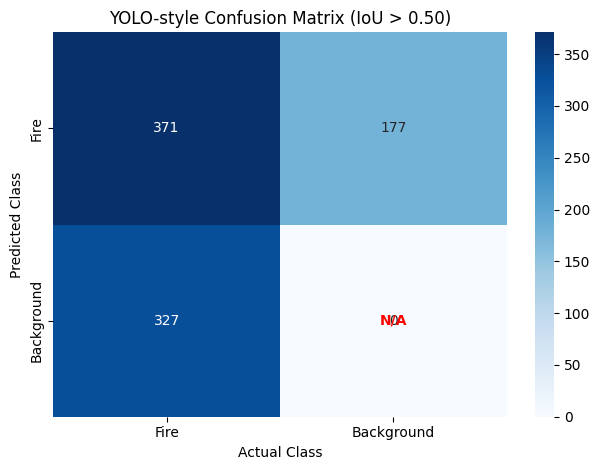

{'Total Predicted Boxes': 548, 'Total Ground Truth Boxes': 698, 'True Positives': 371, 'False Positives': 177, 'False Negatives': 327, 'Average IoU (on matched boxes)': np.float32(0.7751504), 'mAP@0.5': np.float64(0.8876811594202898), 'Precision': 0.677007299270073, 'Recall': 0.5315186246418339, 'F1-Score': 0.5955056179775281}


In [39]:

results = evaluate_moe("../DataSets/combined_val_dataset/images", "../DataSets/combined_val_dataset/labels")
print(results)

In [30]:
from tabulate import tabulate
def pretty_print_results(results_dict):
    table = [[k, f"{v:.4f}" if isinstance(v, float) else v] for k, v in results_dict.items()]
    print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

pretty_print_results(results)

╒════════════════════════════════╤═══════════╕
│ Metric                         │     Value │
╞════════════════════════════════╪═══════════╡
│ Total Predicted Boxes          │ 548       │
├────────────────────────────────┼───────────┤
│ Total Ground Truth Boxes       │ 698       │
├────────────────────────────────┼───────────┤
│ True Positives                 │ 371       │
├────────────────────────────────┼───────────┤
│ False Positives                │ 177       │
├────────────────────────────────┼───────────┤
│ False Negatives                │ 327       │
├────────────────────────────────┼───────────┤
│ Average IoU (on matched boxes) │   0.77515 │
├────────────────────────────────┼───────────┤
│ mAP@0.5                        │   0.8877  │
├────────────────────────────────┼───────────┤
│ Precision                      │   0.677   │
├────────────────────────────────┼───────────┤
│ Recall                         │   0.5315  │
├────────────────────────────────┼───────────┤
│ F1-Score   

In [10]:
import matplotlib.pyplot as plt
import cv2

def visualize_boxes(image_path, boxes_list):
    image = cv2.imread(image_path)

    for boxes in boxes_list:
        for i in range(len(boxes)):
            x1, y1, x2, y2 = map(int, boxes.xyxy[i].tolist())
            conf = float(boxes.conf[i].item())
            cls_id = int(boxes.cls[i].item())
            label = f"{cls_id} ({conf:.2f})"
            cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


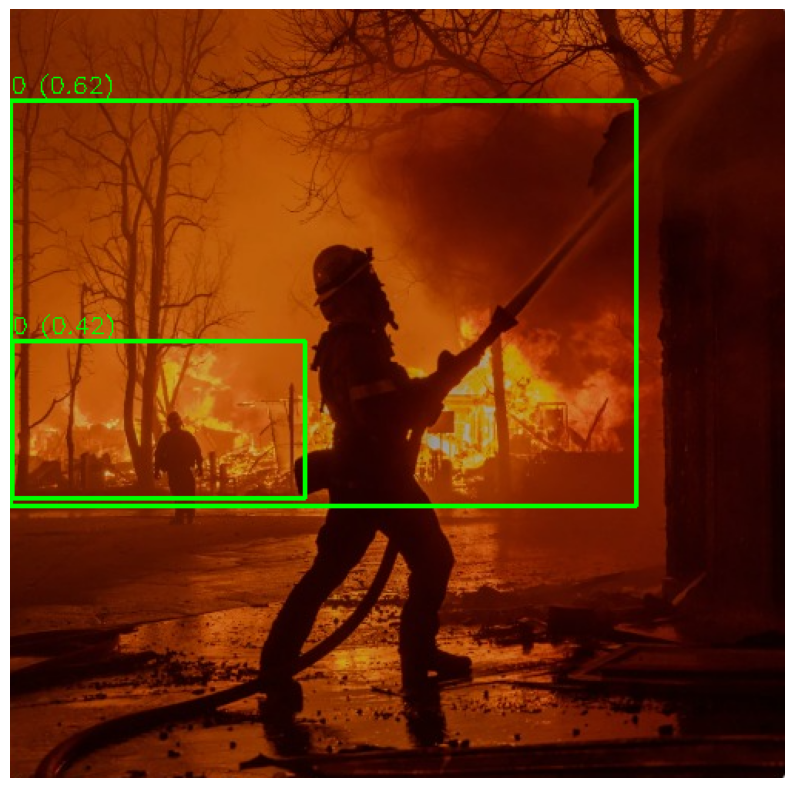

In [11]:
image_path = "Screenshot 2025-04-30 032725.png"  # update with a real path
final_boxes = run_moe(image_path)
visualize_boxes(image_path, final_boxes)
